## Setting up the data

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from datetime import datetime
from pandas.io.json import json_normalize
import seaborn as sns
from statsmodels.regression.linear_model import OLS as reg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn

In [2]:
import warnings
warnings.filterwarnings('ignore')
#use 'default' to show warnings and 'ignore' to hide warnings

In [3]:
with open('/Users/Work/Desktop/Springboard/data/yelp_dataset_challenge_academic_dataset/\
yelp_academic_dataset_business.json', 'rb') as f:
    data = f.readlines()
data_json_str = "[" + ','.join(data) + "]"
df = pd.read_json(data_json_str)

In [4]:
starbucks=df[df.name.str.contains('Starbucks')]

In [5]:
import pickle
o = open('/Users/Work/Desktop/Springboard/data/yelp_dataset_challenge_academic_dataset/\
reviews_pickle.pkl','r')
reviews=pickle.load(o) 
o.close()

In [6]:
df2=pd.DataFrame(reviews)

## Year predictor variable

In [23]:
df2.date=pd.to_datetime(df2.date)

In [8]:
temp=[]
for j in range(len(df2)):
    temp.append(df2.date[j].year)
df2['year']=temp

In [9]:
avg_year=pd.DataFrame(df2.groupby('business_id').mean().year).reset_index()
avg_year.columns=['business_id','mean_review_year']
starbucks=pd.merge(avg_year,starbucks,on='business_id')
starbucks['mean_review_year_rounded']=starbucks.mean_review_year.round()

## Region and State Predictors

In [10]:
Northeast=['CT','ME','MA','NH','RI','VT','NJ','NY','PA']
Midwest=['IL','IN','MI','OH','WI','IA','KS','MN','MO','NE','ND','SD']
South=['DE','DC','FL','GA','MD','NC','SC','VA','WV']
West=['AZ','CO','ID','MT','NV','NM','UT','WY','AK','CA','HI','OR','WA']
Canada=['EDH','BW','ON','QC']

In [11]:
temp=[]
for x in range(len(starbucks)):
    if starbucks['state'].iloc[x] in Northeast:
        temp.append('Northeast')
    elif starbucks['state'].iloc[x] in Midwest:
        temp.append('Midwest')
    elif starbucks['state'].iloc[x] in South:
        temp.append('South')
    elif starbucks['state'].iloc[x] in West:
        temp.append('West')
    elif starbucks['state'].iloc[x] in Canada:
        temp.append('Canada')
    else:
        temp.append('NA')
starbucks['region']=temp

## Indicator Variables

### Cleanliness

In [12]:
unclean=df2[(df2.text.str.contains('dirty')) | (df2.text.str.contains('filthy')) |
          (df2.text.str.contains('messy'))].business_id.unique()
#starbucks['clean'] = starbucks['business_id'].map( lambda x: 'not_clean' if x in list(list(unclean)) else 'clean')
starbucks['unclean'] = starbucks['business_id'].map( lambda x: 1 if x in list(list(unclean)) else 0)

### Homeless Problem

In [13]:
homeless=df2[df2.text.str.contains('homeless')].business_id.unique()
starbucks['homeless'] = starbucks['business_id'].map( lambda x: 1 if x in list(list(homeless)) else 0)

### Friendliness

In [14]:
unfriendly=df2[df2.text.str.contains('rude',case=False) | (df2.text.str.contains('mean',case=False))].business_id
starbucks['unfriendly'] = starbucks['business_id'].map( lambda x: 1 if x in list(list(unfriendly)) else 0)

## Creating dummy variables and avoiding the dummy variable trap

In [15]:
X=starbucks[['state','mean_review_year','review_count','unclean','homeless','unfriendly']]
state_dummies=pd.get_dummies(X.state)
X=pd.concat([X,state_dummies],axis=1)
del X['state']
del X['AZ']
#X.review_count=(X.review_count-X.review_count.mean())/X.review_count.std()
#X.mean_review_year=(X.mean_review_year-X.mean_review_year.mean())/X.mean_review_year.std()
Y=starbucks.stars.values

pd.get_dummies creates a dummy variable for each value of state, but we need (number of unique state values) - 1 dummy variables, since there has to be meaning when all state dummy variable values have value zero.  Also, if we did not exclude a category/state variable, any given state variable would perfectly correlate with the other state dummy variables, which would lead to a multicollinearity problem (high standard errors and therefore insignificant p-values for our state variables).  This scenario is called the dummy variable trap.
source: https://www.quora.com/Do-you-include-all-dummy-variables-in-a-regression-model

The dummy variable to exclude as the reference category should typically be the largest/most common category.  If you select a small reference category (one of the least common categories), the other dummies will necessarily have high VIFs (even if they aren't correlated with other variables).  
source: http://statisticalhorizons.com/multicollinearity

There are 11 state values in the data (as shown below), and pd.get_dummies created 11 state dummy variables.  We need 10 dummy variables.  When all variables have value zero, this will represent the observation having a state value that is the state that did NOT get its own dummy variable.  The intercept of the model is then necessary and will reflect the reference state category's effect on y (since all other state variables will have value zero), as well as a store that is regarded as friendly, clean, not having a homeless problem (which is the 0 values for the other dummy variables).  The intercept will not be interpretable though because the two variables review count and mean review year cannot have zero values, since this would not make sense.  

In [24]:
starbucks.groupby(['state']).size()

state
AZ     201
BW       2
EDH     20
IL       3
NC      41
NV     161
ON       6
PA      23
QC      26
SC       1
WI      10
dtype: int64

AZ is the largest category and has 201 observations, as shown above, so I am going to select AZ as the base level state.  Hence I am removing the AZ column.  All other state dummy variable columns will have value zero, which will indicate that the obsevation has state value AZ. The code that deletes X['SC'] is above.  In showing that AZ was successfully removed, I count the number of observations in the regressor matrix with zero values for all state dummy variables.  There are 201, as shown below, which is the number of observations for AZ.   

In [25]:
len(X[(X.BW==0) & (X.EDH==0) & (X.IL==0) & (X.NC==0) & (X.NV==0) & (X.ON==0) & \
(X.PA==0) & (X.QC==0) & (X.WI==0) & (X.SC==0)])

201

## Linear Regression with a Train/Test Split

In [765]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split\
(X, Y, test_size=0.30, random_state = 5)

In [766]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
print 'SSE for training data is %r\nSSE for test data is %r'\
%(np.sum((Y_train-lm.predict(X_train))**2), np.sum((Y_test-lm.predict(X_test))**2))

SSE for training data is 118.56092366496276
SSE for test data is 63.800628248340438


## Validating regression assumptions

(-2, 2.2)

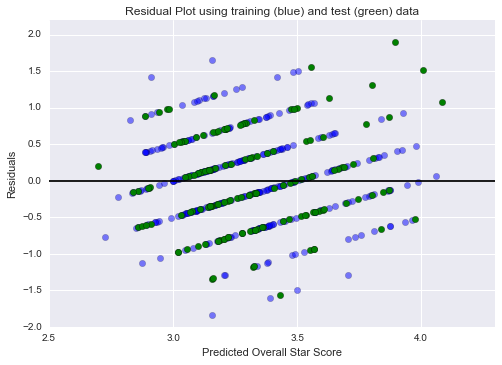

In [20]:
plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=2.5, xmax = 4.5)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.xlabel('Predicted Overall Star Score')
plt.xlim(2.5,4.3)
plt.ylim(-2,2.2)

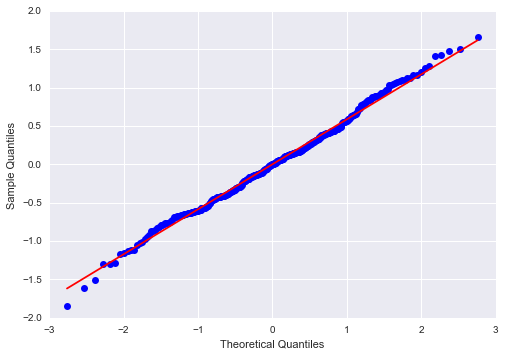

In [33]:
import statsmodels.api as sm
residuals=lm.predict(X_train) - Y_train
sm.qqplot(residuals,line='s')
plt.show()

(array([  3.,   5.,  15.,  54.,  79.,  82.,  57.,  28.,  17.,   5.]),
 array([-1.84127777, -1.49139085, -1.14150392, -0.791617  , -0.44173008,
        -0.09184315,  0.25804377,  0.6079307 ,  0.95781762,  1.30770454,
         1.65759147]),
 <a list of 10 Patch objects>)

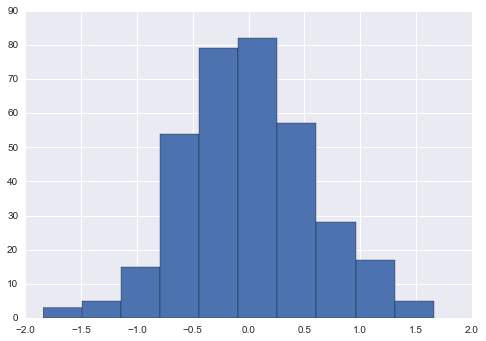

In [34]:
plt.hist(residuals,bins=10)

Linear regression assumptions consist of the following:
1. The relationship between y and the independent variables is linear.
2. The errors are normally distributed.  
3. The errors are uncorrelated (or independent).  
4. The errors have constant variance (same variance across x's), meaning homoscedasticity is present.  

1. I investigated linear relationships in the exploratory data analysis.  
2. Residuals appear to be normally distributed, as shown by the Q-Q plot and histogram above.
3. There appears to be 6 diagonal bands of residuals, and one band each on the top and bottom where both consist of a couple outlier points.  The bands are tilted in a way that suggests residuals increase linearly as predicted stars increases.  I am not sure if this means autocorrelation (correlated residuals) is present, so I'll calculate a durbin watson statistic, which tests for autocorrelation.  There are in fact 8 total unique star scores in customers have given stores in the data, since the min and max y's are (1.5, 8), respectively, and stars can only be given in .5 increments.  Given that there are 8 bands, I am sure this is related somehow to this fact.  
4. In the residual plot above, residuals do not seem to have a larger or smaller spread for a given x value as x increases, so I do not see much evidence of heteroskedasticity.

In testing for autocorrelation using the Durbin-Watson statistic, resultant statistic values always lie between 0 and 4.  Values less than 2 indicate residuals may be positively correlated.  Values greater than 2 indicate residuals may be negatively correlated.  Values close to 2 indicate residuals are not correlated.  

In [747]:
print 'The Durbin Watson Test Statistic Value is %r, which is very close to 2, and\n\
provides evidence that residuals are not correlated.' \
%sm.stats.stattools.durbin_watson(residuals)
#statsmodels.sourceforge.net/devel/generated/statsmodels.stats.stattools.durbin_watson.html

The Durbin Watson Test Statistic Value is 1.9957803180357045, which is very close to 2, and
provides evidence that residuals are not correlated.


The statistic above is very close to 2, providing evidence that residuals are not correlated.

Regression assumptions appear to hold reasonably well.  

## Investigating the goodness-of-fit of the model

The coefficient of determination (r-squared) is as follows:

In [748]:
r2=lm.score(X_train,Y_train)
r2

0.17435016119149505

The adjusted R-squared, which does not automatically increase as we add more predictors to the model, and is hence a more accurate and better measurement of model fit, is as follows:

In [37]:
p=len(X_train.columns) #number of predictors
n=len(X_train) #sample size
1 - ( (n-1)*(1-r2)/np.float(n-p-1) )

0.13670655151937483

The adjusted R-squared is 13.2%, meaning the model explains 13.2% of the variation in overall star score.  This is low and suggests that the model could be significantly improved, given that one would expected the variables being measured to have a definite impact on overall star score (barista friendliness, store cleanliness, homeless problems, state, etc).  The dummy variables account for their measured variables in a simplistic fashion, and I suspect that sentiment analysis on text review content would yield a much more predictive model.    

The statsmodels module provides many goodness of fit statistics.  The r-squared and adjusted r-squared are the same as those generated above using the sklearn module (the estimated intercept and Durbin Watson statistic are the same too), so we know the results are the same in both, and I can use goodness of fit statistics below to further examine the model.

### I am going to use the statsmodels module to produce goodness of fit criteria, and I'll also recreate the regression line using statsmodels. Some information about statsmodels is below:


statsmodels.api does not automatically add an intercept to the model (top code) <br>
statsmodels.formula.api automatically adds an intercept (bottom code) <br>

m=sm.OLS(Y, X).fit() <br>
m.summary()                             (does NOT include intercept) <br>

m=ols('Y~X',X).fit() <br>
m.summary()                             (includes intercept) <br>

To automatically add the intercept to the top code expression, <br>
X= (how it's originally defined) , and then add the following: <br>
X = sm.add_constant(X) <br>
m = sm.OLS(Y,X).fit() <br>


In [761]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('Y_train ~ X_train', X_train).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:                Y_train   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     4.632
Date:                Fri, 30 Dec 2016   Prob (F-statistic):           4.62e-08
Time:                        21:06:38   Log-Likelihood:                -305.28
No. Observations:                 345   AIC:                             642.6
Df Residuals:                     329   BIC:                             704.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     190.2266     75.886      2.507      

The F-statistic value is 4.33.  This means the variation explained by the regression coefficients is 4.33 times the unexplained variation, or that the average explained variation is 4.33 times the average unexplained variation.  The p value associated is 2.26e-07, which means that the null hypothesis that all regression coefficients of the regressors are zero is rejected at all of the usual significance levels (like the 1% level).

The intercept of 162.3914 does not have a practical interpretation because it would not make sense for the variables mean_review_year and review_count to be zero.  

Regressor coefficients with p values less than .05 include X_train[0], X_train[2], X_train[4] and two of the state dummy variables.  Thus, mean review year, the cleanliness dummy variable, the unfriendliness dummy variable and two state dummy variables have regressor coefficients that are statistically significantly different from zero at the .05 significance level.

Notice that all regressors with non-significant p-values at the .05 level have 95% confidence intervals that contain zero.  This means for these regressors, the sign of the coefficient could be negative or positive and within the each's given interval, with 95% confidence.  A statistically significant p-value at the 1% or 5% level won't contain zero, so you'll know the sign of the regressor coefficient with with 99%/95% confidence.  

In [770]:
def rmse(Y_test,Y_pred):   
    return np.sqrt(sklearn.metrics.mean_squared_error(Y_test,Y_pred))

In [771]:
Y_pred=lm.predict(X_test)
rmse(Y_test,Y_pred)

0.65436391701781838

## Multicollinearity

The statsmodels module output provides a warning at the bottom, "The condition number is large, 4.79e+06. This might indicate that there are strong multicollinearity or other numerical problems."  The condition number is 4,790,000.  This is huge.  A condition number greater than 30 is a sign of multicollinearity problems, and a number between 100-1000 is a sign of moderate-several problems.    

The variance inflation factors (VIFs) are all fairly low and are all less than 5.  The greatest VIFs are for mean_review_year and review_count, which have VIFs of 4.77 and 4.27, respectively.  This means that the square of the standard errors for these estimated coefficients (aka the estimated variances of these estimated coefficients) are 4-5 times higher than they otherwise would have been because of correlations between these predictors and other predictors.  

A table of VIFs for each regressor is shown below.  
I created the VIFs from code that I modified and added to, located here:
http://statsmodels.sourceforge.net/devel/_modules/statsmodels/stats/outliers_influence.html#variance_inflation_factor

In [40]:
'''The below code is used to create functions for calculating VIFs

variance_inflation_factor(X,j) takes a matrix X of regressors (where each regressor has its  
own column) and calculates the VIF for the jth column (regressor) where
j starts at 0.

vifs(X) takes a matrix X of regressors and returns a list of VIFs for each regressor
'''


from statsmodels.regression.linear_model import OLS as reg
def variance_inflation_factor(exog, exog_idx):
    k_vars = exog.shape[1] #returns number of columns of exog, 0 would return number of rows
    x_i = exog.ix[:,exog_idx] # I've edited this formula by adding .ix, so you give col index
                              #this produces a series of values of regressor the vif is for
    mask = np.arange(k_vars) != exog_idx  
    # first produces array of column indices of regressor matrix exog, then from this array, 
    # an array of T/F's where only the selected column index (for the vif) gets a False value
    x_noti = exog.ix[:, mask] # edited this by adding .ix.  Produces regressor matrix that
                              #excludes the selected column that the vif is for
    r_squared_i = reg(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i)
    return vif

def vifs(regressor_matrix):
    vifs=[]
    for jth_regressor in range(regressor_matrix.shape[1]):
        vif_j=variance_inflation_factor(regressor_matrix, jth_regressor)
        vifs.append(vif_j)   
    return vifs

In [750]:
X_vifs=pd.DataFrame(X.columns,columns=['Regressor'])
X_vifs['VIF']=vifs(X_train)
X_vifs

,Regressor,VIF
0,mean_review_year,4.838519
1,review_count,4.316291
2,unclean,1.593765
3,homeless,1.085516
4,unfriendly,3.341173
5,BW,1.012663
6,EDH,1.125951
7,IL,1.026680
8,NC,1.225491
9,NV,1.964982


Multicollinearity is always present to a certain degree, and it's not a matter of whether it IS or IS NOT present.  It is ideal for our model to have regressors highly correlated with y, but minimally correlated with each other (if at all). 

## Why is the condition number high if the VIFs are low?

The condition number can sometimes be high (above 30) without there actually being multicollinearity problems.  According to wikipedia, the false flagging of the condition number can be remedied using standardized regressor variables.  If the condition number does actually indicate multicollinearity though, using standardized variables does not actually reduce multicollinearity and can provide a misleading reduction in the vifs and condition number.  Regardless, let's run a regression with standardized regressor variables and observe the results.  
https://en.wikipedia.org/wiki/Multicollinearity

## Rerunning the above regression with standardized quantitative variables

The following code standardizes the quantitative regressor variables to have mean 0 and unit variance (=1).  It is not common practice to standardize dummy variables since it does not make much sense.  Thus, mean_review_year and review_count are standardized.    

In [790]:
from sklearn import preprocessing
temp = pd.DataFrame(preprocessing.scale(X.ix[:,0:2]),columns=X.columns[:2])
import copy	
standardized_X=copy.deepcopy(X)
standardized_X[['mean_review_year','review_count']]=temp[['mean_review_year','review_count']]
standardized_X.head(1)

,mean_review_year,review_count,unclean,homeless,unfriendly,BW,EDH,IL,NC,NV,ON,PA,QC,SC,WI
0,-0.087367,1.722569,0,0,1,0,0,0,0,1,0,0,0,0,0


In [791]:
X.mean_review_year.mean()

2013.477594106229

In [792]:
#Centering quantitative variables as oppossed to standardizing
standardized_X=copy.deepcopy(X)
standardized_X['mean_review_year']=X['mean_review_year']-X['mean_review_year'].mean()
standardized_X['review_count']=X['review_count']-X['review_count'].mean()

In [793]:
standardized_Y=preprocessing.scale(Y)

In [794]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split\
(standardized_X, Y, test_size=0.30, random_state = 5)

In [795]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('Y_train ~ X_train', X_train).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:                Y_train   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     4.632
Date:                Fri, 30 Dec 2016   Prob (F-statistic):           4.62e-08
Time:                        21:18:45   Log-Likelihood:                -305.28
No. Observations:                 345   AIC:                             642.6
Df Residuals:                     329   BIC:                             704.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       3.5663      0.074     48.338      

In [796]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
Y_pred=lm.predict(X_test)
rmse(Y_test,Y_pred)

0.65436391701781982

## Comparing the model with standardized regressors to the one without standardized regressors

Goodness of fit statistics between the two models remain the same: R-squared, adjusted R-squared, F-statistic, the F'statistic's p-value, AIC, and BIC.  Regressor t-values and p-values remain the same (including those of the standardized regressors).  Non-standardized regressor coefficients (the dummy variables), standard errors, and confidence intervals remain the same.  

What has changed includes: <br>
1) coefficients, standard errors, and confidence intervals for the standardized variables (though their t and p-values are the same).<br>
2) the intercept, its standard error, t-value, p-value, and confidence interval <br>
3) the condition number has been reduced to 24.8, so this solution did the trick and it looks the condition number is not indicating a multicollinearity problem. <br>
4) The vifs for every regressor have changed.  Variables with more problematic vifs have seen their vifs decrease substantially (as shown below): mean_review_year, review_count, and the friendliness dummy variable's vifs have decreased from (4.77, 4.27, and 3.35) down to (1.25, 1.54, and 1.99), respectively.  All other variables, which had vifs under 2, have changed very little.


The coefficient of -0.0789 for standardized mean_review_year can be interpreted as follows:
When there is a one-unit increase in standardized mean_review_year, meaning when mean_review_year increases by one standard deviation, then we predict the overall star score to decrease by .0789, holding all other variables constant.  

## Centering vs Standardizing and how you can't do this to reduce multicollinearity

The same exact model results from x-standardization can be achieved by centering the two quantitative variables about their means.  Standardizing our variables is the action of centering AND scaling, so the centering of our regressors in the above x-standardization is what is really changing the modeling results.  To center our quantitative regressors about their means, just subtract from each regressor's values its sample mean.      

While standardizing/centering the variables lowers the condition number and vifs, suggesting that it decreases the presence of multicollinearity, this is actually not the case.  Some resources purport that centering reduces multicollinearity, but this claim is widely regarded as incorrect.  An academic paper titled "Moderating effects, the myth of mean centering" (source 1), writes that, "mean centering does not reduce multicollinearity at all" (page 1).  I've found resources that are spreading the myth, such as the following: on page 580 of "Research Design and Statistical Analysis: Third Edition", the authors write that mean-centering provides "more interpretable coefficients...and will also often reduce multicollinearity".  

In a blog post titled, "Mean-centering Does Nothing for Multicollinearity!", the author maintains the following:

Centering the data does not change the level of multicollinearity in the data.  However, it DOES affect the vifs, which are thus not immune to mean centering.  Since vifs are used to measure the level of multicollinearity present, and they might get reduced from having centered the data, then this provides a misleading indication that multicollinearity is reduced when it is not.  The author writes that "[y]our numbers will change to sound acceptably lower, but...[c]hanging the numbers used to describe the problem doesn't change the problem".  Mean-centering to lower vifs is equivalent to "switching your speedometer from miles per hour to nautical miles per hour...to reduce the severity of a car accident" (source 2).

1) https://flora.insead.edu/fichiersti_wp/inseadwp2005/2005-30.pdf
2) http://ordinary-gentlemen.com/2015/07/02/mean-centering-does-nothing-for-multicollinearity/
 

In [48]:
X_stan_vifs=pd.DataFrame(standardized_X.columns,columns=['Regressor'])
X_stan_vifs['VIF']=vifs(X_train)
X_stan_vifs

,Regressor,VIF
0,mean_review_year,1.221205
1,review_count,1.543484
2,unclean,1.454897
3,homeless,1.089596
4,unfriendly,2.008130
5,BW,1.084765
6,EDH,1.152545
7,IL,1.015952
8,NC,1.100915
9,NV,1.432673


## Principal Components Regression

Principal components regression (PCR) is the act of regressing the dependent variable on the principal components of the data.  It is a "biased regression technique" in that we omit principal components close to zero, and this omission necessarily entails that we are approximating the data (though this may be a good approximation).  Thus our parameter estimates will necessarily be biased.  This technique is a last resort for reducing multicollinearity, and should be considered only after having tried other solutions (source 1)

Using principal component regression offers several potential benefits: <br>
1) You can perform dimensionality reduction on the predictors, which will reduce the model's complexity.  There is a principal component for every predictor, so by NOT selecting all of the principal components, you'll have reduced the dimensionality of the data.  Selecting too many principal components may result in PCR performing worse than linear regression.  Ideally, it is best to have most of the variation in the original data explained by just a small subset of principal components (the ones with the biggest eigenvalues).  

2) You can reduce the presence of multicollinearity by using less than the total number of principal components.

3) You can reduce the risk of overfitting the model since using less variables via dimensionality reduction means having to estimate less coefficients.  <br>

source 1: http://www4.ncsu.edu/~slrace/LinearAlgebra2016/Solutions/solution6.pdf <br>
source 2: https://www.r-bloggers.com/performing-principal-components-regression-pcr-in-r/

## Can we use Principal Components Analysis (PCA) given that we have dummy variables?

PCA is often used for dimensionality reduction when all variables are quantitative.  Multiple Correspondence Analysis (MCA) is often used when all variables are categorical.  What about when variables are mixed (quantitative AND qualitative?), which is the case for my model?  

PCA can be used for a mixture of variable types (according to source (1)), though the results might not be perfect.   

1) http://data-mining-tutorials.blogspot.com/2013/03/factor-analysis-for-mixed-data.html

## Generating the eigenvalues and eigenvectors

Extracting eigenvalues and eigenvectors from the correlation or covariance matrix of the 
predictor data is done as follows, and you'll get an array of eigenvalues and an array 
eigenvector coeffients:

scipy.linalg.eig(X.corr())
scipy.linalg.eig(X.cov())

scipy.linalg.eig(X.corr())[0]            returns eigenvalues
scipy.linalg.eigvals(X.corr())           also just returns eigenvalues

evals, evecs = np.scipy.eig(X.corr)
eval1 = evals[0]
evec1 = evecs[:,0]

The eigenvector array is an array consisting of arrays.
Each array represents a row of the nxn eigenvector matrix (for n predictors).
The nth value of each array represents column n (eigenvector n) of the eigenvector matrix 
If evecs represents this array, then,
evecs = [ [array1 values], [array2 values], [array3 values] ] 
evecs[0]  = [array1 values] = row 0
evecs[:,0] = [ first value of each array ] = the first eigenvector
pd.DataFrame[evecs] properly shows the eigenvector matrix  because it interprets each array as
a row.

I will generate eigenvectors and eigenvalues from the covariance matrix to verify that my principal components code is correct.  I'll do this by verifying that the variances of the principal component scores match the eigenvalues and that the sum of the eigenvalues matches the sum of the variances of the predictors.  It is best to generate principal components from the correlation matrix though, which is equivalent to standarizing your predictors, so I'll do this for the regression analysis.

In [49]:
import scipy
evals,evecs=scipy.linalg.eig(X.cov())
eigenvectors=pd.DataFrame(evecs)
eigenvectors.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.005825,0.993451,0.085929,0.055952,-0.020628,0.002599,0.022877,0.009369,-0.005831,-0.026491,0.004666,0.019413,0.001639,-0.017879,0.002422
1,0.999779,0.004232,0.005372,0.015640,-0.011744,-0.002082,-0.000189,0.000626,0.002005,-0.001470,0.000790,0.000707,0.000077,0.000014,-0.000005


The eigenvalues are given as complex numbers with a coefficient of zero on the imaginary part, so I'm going to convert them to float format, as shown below.  Also, I've generated principal component scores, which are the values of the principal components.  The variance of each principal component's scores should equal that principal component's eigenvalue, and the sum of the eigenvalues equals the sum of the variances of the predictor variables.  Thus, the sum of the principal component variances should equal the sum of variances of the predictor variables and should thus explain all of the variation in the predictors.  I verify that the variances of the principal component scores matches the eigenvalues, as shown below as well.

In [50]:
temp=[]
eigenvalues=pd.DataFrame(evals)[0]
for j in range(len(eigenvalues)):
    temp.append(np.float(eigenvalues[j]))
eigenvalues=pd.DataFrame(temp)[0]
pd.DataFrame(eigenvalues.sort_values(ascending=False)).T

,0,1,2,3,4,5,6,7,8,9,10,11,14,13,12
0,257.568716,0.88857,0.21424,0.182858,0.150227,0.074246,0.049073,0.043393,0.039268,0.031721,0.018916,0.011112,0.005962,0.003718,0.002001


In [51]:
scores=pd.DataFrame()
for j in range(0,len(eigenvectors)):
    scores[j]=np.dot(X,eigenvectors[j])
pd.DataFrame((scores.std()**2)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,257.568716,0.88857,0.21424,0.182858,0.150227,0.074246,0.049073,0.043393,0.039268,0.031721,0.018916,0.011112,0.002001,0.003718,0.005962


**We can verify that we have the correct eigenvalues for<br>**
**1)** PCA done on the correlation matrix, by verifying that the sum of the eigenvalues equals the sum of the standardized predictor variances (meaning the sum of the trace(correlation matrix)).  Using the correlation matrix in PCA is equivalent to standardizing our predictors to have unit variances (variances of 1), which is what the values are along the diagonal of the correlation matrix (it consists of 1's).  So we know the sum of our eigenvalues should equal the number of variables.  <br>
**2)** PCA done on the covariance matrix, by verifying that the sum of the eigenvalues equals the sum of the predictor variances (meaning the sum of the trace(covariance matrix)).  

The sum of our predictor variances and standardized predictor variances, as shown below, should match the sum of our eigenvalues for PCA done on the covariance and correlation matrix (also shown below, respectively):

In [52]:
np.trace(X.cov()), np.trace(X.corr())

(259.28402110043487, 15.0)

In [53]:
temp0=[]
temp1=pd.DataFrame(scipy.linalg.eig(X.cov())[0])
for j in range(len(temp1)):
    temp0.append(np.float(temp1[0][j]))
temp2=[]
temp3=pd.DataFrame(scipy.linalg.eig(X.corr())[0])
for j in range(len(temp3)):
    temp2.append(np.float(temp3[0][j]))
np.sum(pd.DataFrame(temp0)).item(),np.sum(pd.DataFrame(temp2)).item()

(259.28402110043464, 15.0)

In [ ]:
#this used to work, what happened?????
#np.sum(pd.DataFrame(scipy.linalg.eig(X.cov())[0])[0].apply(f)), \
#np.sum(pd.DataFrame(scipy.linalg.eig(X.corr())[0])[0].apply(f))

## Verifying that manually calculating principal component scores using the scipy module matches those automatically generated from the sklearn module

I can generate principal component scores using the following code, where I multiply eigenvectors generated from the correlation matrix by standardized regressors.  Regressors are standardized because eigenvectors generated from the correlation matrix are equivalent to standardizing regressors and then generating eigenvectors from the covariance matrix.  

In [54]:
from sklearn.preprocessing import normalize, scale
evals,evecs=scipy.linalg.eig(X.corr())
eigenvectors=pd.DataFrame(evecs)

scores=pd.DataFrame()
for j in range(0,len(eigenvectors)):
    scores[j]=np.dot(scale(X),eigenvectors[j])
scores.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.807268,-0.795901,-0.314871,-0.510892,0.607629,0.779729,1.050846,0.062781,-0.122791,-0.272909,-0.037411,0.010897,0.084312,-0.052585,-0.033877
1,-0.748844,0.351024,0.100155,-0.645575,1.059277,-0.776077,1.287054,0.471318,-0.453906,-0.159592,-0.271972,0.013736,0.097066,0.147575,-0.109744
2,1.209284,0.556524,0.389719,0.139938,-1.008005,-0.309087,-0.767120,-1.016238,0.090876,0.510876,0.226465,0.447944,-0.098049,0.059434,0.109500
3,2.439342,0.181188,-0.496249,-0.206734,0.187442,-0.618350,0.458869,-0.923325,-0.041197,0.372298,-0.023439,0.577323,-0.059171,0.135539,-0.002889


In [55]:
#The scale function in sklearn's preprocessing package gives variables (m=0, std=1)
print 'means: %r  \nsds: %r' %(scale(X).mean(axis=0)[:2], scale(X).std(axis=0)[:2])

means: array([  2.24911408e-13,  -2.15751843e-17])  
sds: array([ 1.,  1.])


Variances of principal components are shown below:

In [56]:
pd.DataFrame((scores.std()**2)).T.ix[:,:3]

,0,1,2,3
0,2.035233,0.401702,0.462263,1.390651


Alternatively, principal component scores can be generated from the sklearn module:

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, scale
pca = PCA(n_components=2)
X_stan=pd.DataFrame(scale(X))
X_reduced = pca.fit_transform(X_stan)
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
# http://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python
# http://scikit-learn.org/stable/modules/preprocessing.html

Principal components are given in order in the output of the sklearn module, unlike in the scipy module, which does not give principal components in order.  Notice that the variances of the first two principal components from sklearn matches the variances of scipy principal components that have indices 0 and 3.  Principal components are ordered based on the size of their variances, meaning their eigenvalues.

In [58]:
X_reduced = pca.transform(X_stan)
two_pca=pd.DataFrame(X_reduced)
two_pca.std()**2

0    2.035233
1    1.390651
dtype: float64

## Determining how many principal components to use in a principal components regression

In choosing the number of principal components to retain in principal components analysis, consider the following methods:

**1)** Retain enough components to explain some specified percentage of the total variation of the variables, usually around 80%.
**2)** Exclude principal components whose eigenvalues are less than the average: sum(lambdas) / # of components.  
**3)** Make a scree plot (eigenvalue vs principal component number), where the larger the number of the principal component, the smaller the eigenvalue.  Select the number of components equal to the number of the component at the elbow of the curve, where the slope changes from steep to shallow and remains fairly level afterwards.  
**4)** Exclude principal components whose eigenvalues are close to zero (this is needed for a principal components regression in which we want to reduce multicollinearity)

For a principal components regression, where the goal is to reduce multicollinearity, we need to omit principal components whose eigenvalues are close to zero.  These principal components have variances close to zero (since their eigenvalue=their variance), making them close to being constant, making them correlated with the intercept (close to being a multiple of the intercept).  You won't reduce multicollinearity by including principal components that are correlated with the intercept, since multicollinearity is, by definition, the presence of correlation among the predictor variables.  Variables that are correlated with the intercept are included in this definition.  

 
source 1) Introduction to Linear Regression Analysis - Fifth Edition <br>
source 2) http://www4.ncsu.edu/~slrace/LinearAlgebra2016/Solutions/solution6.pdf <br>
source 3) http://stat.ethz.ch/~mmarloes/teaching/fall08/Notes3.pdf (for 1-3)

Eigenvalues generated from the correlation matrix are shown below:

In [59]:
temp=[]
eigenvalues=pd.DataFrame(evals)[0]
for j in range(len(eigenvalues)):
    temp.append(np.float(eigenvalues[j]))
eigenvalues=pd.DataFrame(temp)[0]
eigenvalues=pd.DataFrame(list(eigenvalues.sort_values(ascending=False))).T
eigenvalues

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.031113,1.387835,1.165453,1.076992,1.058159,1.047012,1.036619,1.013886,1.012616,0.95365,0.915962,0.73367,0.704817,0.461327,0.400889


Under method 1, as specified above, the minimum number of principal components to retain such that at least 80% of the variation of the predictor variables is retained is 10.  Thus, method 1 recommends 10 principal components.  See the Variance Explained plot below, and look at the "Cumulative" line.  The point on this line associated with principal component j represents the proportion of variation explained by the first (j+1) principal components (meaning all components before component j, as well as component j).  I've also included a line showing the non-cumulative proportions--the proportion of variation explained by each principal component.  

10 principal components is a lot, considering that there are 14 principal components.  This means that the first several principal components do not retain much of the information in the original data.  

Also shown below is an array of the proportion of total variation explained by each component and all components below each component.  

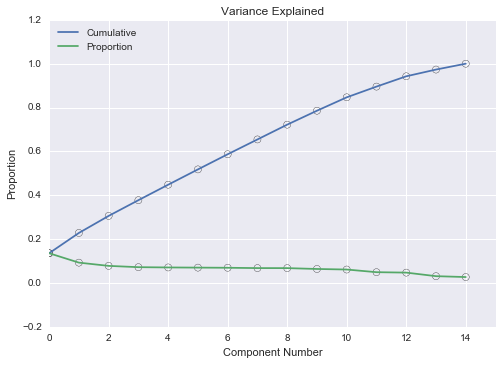

In [60]:
total_variation=np.sum(eigenvalues.values)
cum_variation=[]
cum=0
for j in range(len(eigenvalues.columns)):  
    cum=cum+eigenvalues[j].item()
    cum_variation.append(cum)
Cum_Variance_Explained=cum_variation/total_variation
Variance_Explained=eigenvalues.values[0]/total_variation

x=eigenvalues.columns.values
y=Cum_Variance_Explained
y2=Variance_Explained
plt.xlim(0,15)
plt.scatter(x,y,s=50,facecolors='none')
plt.scatter(x,y2,s=50,facecolors='none')
plt.plot(x,y,x,y2)
plt.xlabel('Component Number')
plt.ylabel('Proportion')
plt.legend(['Cumulative','Proportion'],loc='upper left')
plt.title('Variance Explained')

In [61]:
Cum_Variance_Explained

array([ 0.13540754,  0.22792991,  0.30562676,  0.37742619,  0.44797012,
        0.51777094,  0.58687887,  0.6544713 ,  0.72197902,  0.7855557 ,
        0.84661982,  0.89553116,  0.94251893,  0.97327406,  1.        ])

Under method 2, where we exclude principal components whose eigenvalues are less than the average eigenvalue, 8 components are recommended.  The mean eigenvalue is 1, as shown below.  There are 8 components whose eigenvalues are greater than a value of 1.

In [62]:
eigenvalues.values[0].mean()

1.0

Under method 3, there appears to be an elbow in the scree plot at around 2-3 principal components, however, the first two principal components only explain 32% of the variation of the original data.  Using the elbow rule to select components would not result in the components retaining much of the variance of the original data.  

In [63]:
y

array([ 0.13540754,  0.22792991,  0.30562676,  0.37742619,  0.44797012,
        0.51777094,  0.58687887,  0.6544713 ,  0.72197902,  0.7855557 ,
        0.84661982,  0.89553116,  0.94251893,  0.97327406,  1.        ])

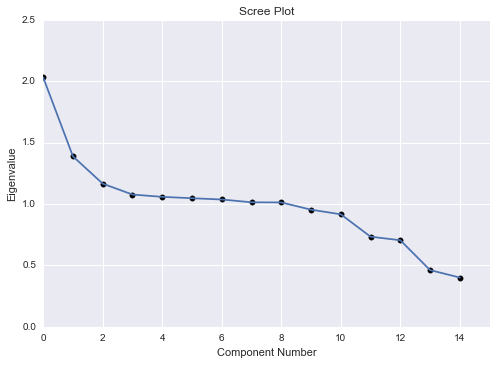

In [64]:
temp=[]
eigenvalues=pd.DataFrame(evals)[0]
for j in range(len(eigenvalues)):
    temp.append(np.float(eigenvalues[j]))
eigenvalues=pd.DataFrame(temp)[0]

x=eigenvalues.index.values
y=pd.DataFrame(list(eigenvalues.sort_values(ascending=False)))[0].values
plt.xlim(0,15)
plt.scatter(x,y,c='k',s=30)
plt.plot(x,y)
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')

Under method 4, arguably the most important method for a principal components regression, we exclude all principal components with eigenvalues close to zero.  Shown below, the last two components are closer to zero than the others (<.5), so these two should at least be excluded to reduce multicollinearity.   

In [65]:
pd.DataFrame(list(eigenvalues.sort_values(ascending=False)))[0].values

array([ 2.03111317,  1.38783544,  1.16545276,  1.07699152,  1.05815894,
        1.04701224,  1.03661903,  1.01388638,  1.01261583,  0.95365015,
        0.91596182,  0.7336701 ,  0.70481659,  0.46132689,  0.40088915])

The methods recommend retaining between 3-12 principal components.  Three components would not result in much of the variation being explained.  I will select 10 principal components, so that 80% of the variation in the data is explained and components with eigenvalues close to zero are excluded.    

## Running the principal components regression

In [786]:
pca = PCA(n_components=10)
X_stan=pd.DataFrame(scale(X))
X_reduced = pd.DataFrame(pca.fit_transform(X_stan))

In [787]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split\
(X_reduced, Y, test_size=0.30, random_state = 5)

In [788]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('Y_train ~ X_train', X_train).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:                Y_train   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     5.156
Date:                Fri, 30 Dec 2016   Prob (F-statistic):           5.01e-07
Time:                        21:17:42   Log-Likelihood:                -313.57
No. Observations:                 345   AIC:                             649.1
Df Residuals:                     334   BIC:                             691.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.3044      0.033    100.457      0.0

In [789]:
lm = LinearRegression()
lm.fit(X_train, Y_train)
Y_pred=lm.predict(X_test)
rmse(Y_test,Y_pred)

0.64525272245601428

## MODEL COMPARISONS

# Random Forests

In [799]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split\
(X, Y, test_size=0.30, random_state = 5)

## Investigating the effect on the root mean squared error of changing the model parameters max_features and n_estimators

Below, I will investigate the impact of model parameters max_features and n_estimators.  A max_features value of none indicates all features are considered in choosing the best split in each tree.

In [800]:
RANDOM_STATE = 112
from collections import OrderedDict

ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='None'",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=.10",
        RandomForestRegressor(warm_start=True, max_features=.1,
                               oob_score=True,
                               random_state=RANDOM_STATE)),    
    ("RandomForestRegressor, max_features=.30",
        RandomForestRegressor(warm_start=True, max_features=.3,
                               oob_score=True,
                               random_state=RANDOM_STATE)),    
    ("RandomForestRegressor, max_features=.50",
        RandomForestRegressor(warm_start=True, max_features=.5,
                               oob_score=True,
                               random_state=RANDOM_STATE)),  
    ("RandomForestRegressor, max_features=.80",
        RandomForestRegressor(warm_start=True, max_features=.8,
                               oob_score=True,
                               random_state=RANDOM_STATE)),    
]


# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

In [801]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
rmse_list = OrderedDict((j, []) for j, _ in ensemble_clfs)
rmse_list

OrderedDict([("RandomForestRegressor, max_features='sqrt'", []),
             ("RandomForestRegressor, max_features='None'", []),
             ('RandomForestRegressor, max_features=.10', []),
             ('RandomForestRegressor, max_features=.30', []),
             ('RandomForestRegressor, max_features=.50', []),
             ('RandomForestRegressor, max_features=.80', [])])

In [802]:
#Generate an rmse for each number of trees used in each of the three models
# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

#Fit a model for each number of max_features and each number of trees
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, Y_train)
        
        #Record the rmse for each `n_estimators=i` setting.
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(Y_test, clf.predict(X_test)))
        rmse_list[label].append((i, rmse))

In [427]:
#rmse_list.items()[i] gives the label data and tuples of model with the ith max_feature value
#rmse_list.items()[i][0] gives the label data of the model with the ith max_feature value
#rmse_list.items()[i][1] gives a list of tuples (# of trees,rmse) of the ith max_feature model

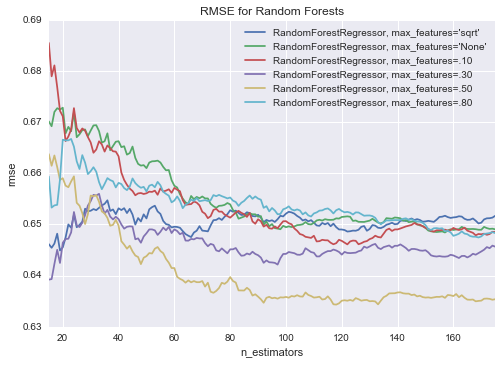

In [803]:
# Generate the "rmse" vs. "n_estimators" plot.
for label, clf_rmse in rmse_list.items():
    xs, ys = zip(*clf_rmse)
    plt.plot(xs, ys, label=label)
    
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.legend(loc="upper right")
plt.title('RMSE for Random Forests')
plt.show()

Above, we see that rmse values stay fairly level for a given max_features value after about 100 trees, so we won't see much (if any) of a performance gain by increasing the number of trees beyond this.  I will use 300 trees to be sure that I do not miss any loss in performance from using too small of an n_estimators value.  

There is a different curve for each considered max_features value.  Generating random subsets whose size is 50% of the total number of features results in the lowest rmse values.  30% is the next best max_features value.  All other max_features values result in curves that have rmse values around .65 for tree values greater than 100.  Clearly, max_features makes a difference, so I will tune this parameter using GridSearchCV.  

## Creating the model by tuning the max_features parameter using GridSearchCV

From having looked at the rmse plot above, I decided to use 300 trees.  I also decided to tune the max_features parameter using GridSearchCV, which I will do below, as well as generate the model.

GridSearchCV uses K-fold cross validation to tune/optimize parameters of an estimator, which in this case is the Random Forest Regressor.  I will look for an optimal max_features value, which is the maximum number of features to draw a random subset of features from at each split in each decision tree comprising the random forest.  <br>

For each considered parameter value, GridSearchCV calculates a cross validation score (cv score), which is the average score using that parameter from k models, where each model is fitted from the other (k-1) folds that the training data was divided into (where each of the k folds is treated as a validation fold, with the other k-1 folds as training folds).  The parameter that has the highest cv score is used in the model, which is then evaluated on the test set (the train split was split into training and validation sets used for tuning the parameters). <br>

The cv parameter controls the number of folds to use in finding the best parameters.  In this case, I'll use 5 folds, meaning I'll generate 5 models for each considered max_features value and calculate the average score for each max_features value. <br>  

The score in this case is the negative of the mean squared error.  Sklearn scores follow the convention of higher means better, and since lower means better for mean squared error, they stuck a negative sign in front to keep this score metric congruent with their convention.  

In [724]:
from sklearn.grid_search import GridSearchCV
clf=RandomForestRegressor(warm_start=True, oob_score=True,random_state=RANDOM_STATE,
                         n_estimators=300)
parameters={"max_features":[None,'sqrt',.1,.2,.3,.4,.5,.6,.7,.8,.9]}
fitmodel = GridSearchCV(clf, param_grid=parameters, cv=5, scoring="neg_mean_squared_error")
fitmodel.fit(X_train, Y_train)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=0.1, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=112, verbose=0, warm_start=True),
 {'max_features': 0.1},
 -0.3917144605567583,
 [mean: -0.43751, std: 0.07967, params: {'max_features': None},
  mean: -0.39686, std: 0.05727, params: {'max_features': 'sqrt'},
  mean: -0.39171, std: 0.05333, params: {'max_features': 0.1},
  mean: -0.39686, std: 0.05727, params: {'max_features': 0.2},
  mean: -0.40097, std: 0.06106, params: {'max_features': 0.3},
  mean: -0.40865, std: 0.06498, params: {'max_features': 0.4},
  mean: -0.41391, std: 0.06526, params: {'max_features': 0.5},
  mean: -0.41478, std: 0.07162, params: {'max_features': 0.6},
  mean: -0.41954, std: 0.07386, params: {'max_features': 0.7},
  mean: -0.42564, std: 0.07820, para

As shown below, the root mean squared error of the model is .65, indicating that the typical amount by which a predicted test set star score deviates from its actual value is .65.  

In [808]:
def rmse(Y_test,Y_pred):   
    return np.sqrt(sklearn.metrics.mean_squared_error(Y_test,Y_pred))

clf=RandomForestRegressor(warm_start=True, oob_score=True,random_state=RANDOM_STATE,
                         n_estimators=300, max_features=fitmodel.best_params_['max_features'])
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)
rmse(Y_test,Y_pred)

0.64949034403249839

**RMSE** <br>
Principal Components Regression: 0.64525 <br>
Random Forest:        0.64949  <br>
Linear Regression:    0.65436  <br>

In [221]:
%timeit()

10000000 loops, best of 3: 25.9 ns per loop


In [201]:
confusion_matrix=pd.crosstab(index=Y_test,columns=predictions,rownames=\
            ['actual'],colnames=['predicted'])

## The Condition Number

The condition number can be calculated as the ratio of the largest eigenvalue to the smallest eigenvalue, where the eigenvalues are calculated from the sample correlation matrix (which, is equivalent to producing eigenvalues from a sample covariance matrix that is based on variables standardized to have unit variance--a variance of 1; thus PCA done on a correlation matrix is the same as PCA done on a covariance matrix with standardized variables).  

The following sources define the condition number as the ratio of the maximum and minimum eigenvalues.  Other sources mention the condition number as the square root of the maximum and minimum eigenvalues such as in source (3).  Source (3) recommends that the condition number "be calculated from a transformed data matrix in which each regressor has unit length", meaning from variables standardized to have a variance of 1.  Calculating variables from the correlation matrix is equivalent to this, as I mention above.    

1) http://amosdevelopment.com/webhelp/conditionnumberofthesamplecorrelationmatrix.htm <br>
2) Introduction to Linear Regression Analysis 5th Edition <br>
3) An Introduction to Modern Econometrics Using Stata by Christopher F. Baum <br>

In [ ]:
pd.DataFrame(scipy.linalg.eig(X.corr())[0])[0].apply(f)[0]\
/pd.DataFrame(scipy.linalg.eig(X.corr())[0])[0].apply(f)[14]

The condition number above is calculated as the largest eigenvalue divided by the smallest eigenvalue.  

In [ ]:
Normalizing Regressor Variables

## Normalizing Regressor Variables

Normalization of all predictor variables is the act of re-scaling them to have the same range of values, such as between [0,1] or [-1,1].  A drawback of normalization, unlike with standardization, is the normalized variable has a smaller standard deviation and the effect of outliers is suppressed.  A common re-scaling is ( (x-xmin)/(xmax-xmin) ).

## Standardizing Regressor Variables

Standardization of all predictors is the act of re-scaling them to have mean zero and unit variances (or unit length), so "they'll have the properties of the standard normal distribution" (1).  A standardized value is interpreted as the number of standard deviations the original value is from the mean, or equivalently, the difference from the mean in number of standard deviations.  For example, -3 indicates that the value is 3 standard deviations below the mean.  A standardized regression coefficient, is one calculated from a 


**1) Both the dependent and independent variables can be standardized (full standardization or fully standardized coefficients)**<br>
If you standardize both, then the standardized regression coefficients are interpreted as how many standard deviations the dependent variable changes per standard deviation increase in the predictor variable.  This does not mean the actual standard deviations change for both variables, but that the amount of change is EXPRESSED in standard deviations.  Thus, it represents how much y will change in number of standard deviations if the x value increases by 1 standard deviation.

When all variables are standardized, the intercept becomes zero.  When all standardized predictors have value zero, then they are at their mean value because each is 0 sd's away from their mean.  Since the least squares regression line must pass through (mean x, mean y), this means that the predicted y must also be 0 sds from its mean in order for it to be equal to its mean value, since the predictors are at their mean values (source 5).  

Regression coefficients based on having standardized all variables (x's and y) are called standardized regression coefficients (though as shown below, it doesn't have to be all variables).  These are actually the same thing as the regression coefficients calculated from unstandardized coefficients and then multiplying each by their respective standard deviation and dividing by the standard deviation of the dependent variable.  

Bi-standardized = (Bi-unstandardized) (sd.i/sd.y)  
(source 7)

**2) Just the independent variables can be standardized (x-standardized coefficients).** <br>
The standardized regression coefficients are interpreted as the average change in the dependent variable per 1 standard deviation increase in the predictor variable.  This allows you to still assess the relative importance of predictors while still keeping a more meaningful interpretation of y.  

**3) Just the dependent variable can be standarized (y-standardized coefficients).**<br>
The standardized regression coefficients are interpreted as how many standard deviations y changes for a one unit increase in x.  (source 2)  

**4) Additional information**<br>
a) Just some of the independent variables can standardized.  <br>
b) Many sources advice against standardizing the dummy variables.  Just standardize the quantitative variables (source 4, and source 2). <br>
c) Standardizing (shifting and scaling your variables), regardless of the type of standardization (x,y, full) won't affect the model fit (like R-squared), or the fitted values, since the model is built based on variable correlations.  It also does not affect standardized variable t-values or p-values, as well as non-standardized variable results (source 2 and 6).  <br>
d) Standardizing DOES affect standardized variable coefficients, their standard errors and  confidence intervals, and completely affects all intercept results (observe source 2 data).
e) The type of standardization done (x,y,full) will affect the estimated coefficients, their standard errors, and the confidence intervals (and their interpretations, of course), but not the t-values, p-values.  
f) Standardizing affects VIFs and the condition number.

**5) Why standardize variables?**<br>
Coefficients are primarily standardized to determine which has the greatest effect on Y, meaning which can be regarded as having the greatest relative importance (which has the biggest number).  Simply take the ratio of the two standardized coefficients.  If one standardized coefficient is twice as big, then the regressor is twice as important in its effect on y.  When variables have different units of measurement, then determining which is more important is hard, but standardizing allows us to do it, since we scale them to make them unit less!  

1) http://sebastianraschka.com/Articles/2014_about_feature_scaling.html <br>
2) https://www3.nd.edu/~rwilliam/stats1/x92b.pdf<br>
3) http://polisci.msu.edu/jacoby/icpsr/regress3/lectures/week2/8.RelImport.pdf<br>
4) http://pj.freefaculty.org/guides/stat/Regression/StandardizedBeta/Standardized-1-lecture.pdf <br>
5) http://mezeylab.cb.bscb.cornell.edu/labmembers/documents/supplement%205%20-%20multiple%20regression.pdf<br>
6) http://stats.stackexchange.com/questions/32649/some-of-my-predictors-are-on-very-different-scales-do-i-need-to-transform-them<br>
7) "How to Standardize Regression Coefficients" by Johan Bring

## Identifying multicollinearity:

1) A condition number between 100-1000 indicates moderate-severe multicollinearity.  A number greater than 30 can also indicate it.  

2) A variance inflation factor (VIF) indicates a multicollinearity problem if its value is greater than 4 (just a rule of thumb...some say 5, some say less than 4), where a VIF>10 indicates severe multicollinearity.  If regressors ARE NOT correlated, the VIF will be 1.  VIF=1/tolerance level, so equivalent criterion for the tolerance level would be a tolerance level<.25 indicates multicollinearity problems, though some sources say <.4 also indicates problems.  

3) Look for high pairwise correlations between regressors, since by definition, multicollinearity is when regressors are highly correlated.

4) A regressor that should be highly correlated with the dependent variable (you see a strong correlation in the scatterplot of y vs that variable) has a regression coefficient that is insignificant.  This stems from consequences #1 and #2 (as shown below) since the estimated coefficient of that variable has a standard error that will be large from a strong presence of multicollinearity.  A stronger indication of multicollinearity (besides just one insignificant regressor) is if we see a high r-squared, but few significant t-values (multiple insignificant regressors).     

5) The sign on a regressor coefficient (+/-) is the opposite of what it should be (increasing the size of a house shouldn't cause the house price to decrease).  

6) Adding or removing a regressor greatly changes regression results

## Consequences of multicollinearity include:

1) Standard errors (std devs) of regressor coefficient estimates (b1,b2..) will be large.  Specifically, variables that are correlated will have large standard deviations on their coefficient estimates

2) Due to the large standard errors, confidence intervals of the estimated coefficients will be wider and the t-statistic value will be lower.  Thus, the null hypothesis that the regressor coefficient is zero has a greater chance of being accepted.  

3) Small changes in the data can lead to large changes in the regressor coefficient estimates (even opposite signs) and their standard errors (aka your model results are not robust).  For example, if you drop an observation, this could change the model a lot.  Regarding model robustness, a model is statistically robust if it predicts reliably across different samples of data (meaning even when its estimates are constructed from different samples).  

R-squared can still be high with strong multicollinearity. 

Multicollinearity does not bias results (in that the average estimated parameter will differ from the population parameter).  However, due to the large standard errors, it is very possible that the coefficient estimate we have come up with from our sample is farther the true coefficient.  The standard error of the coefficient estimate is the typical amount by which we expect the estimated coefficient to differ from its mean, where because our estimated coefficient is constructed in a way that makes it unbiased, this causes its mean to be the coefficient if it was constructed from population data (the thing we're estimating, whose value we'd like to know).  So the greater the standard error, the greater the typical amount by which an estimated coefficient calculated from a given sample will potentially differ from the population coefficient.   

Multicollinearity information sources:
http://blog.minitab.com/blog/understanding-statistics/handling-multicollinearity-in-regression-analysis
http://www.brynmawr.edu/socialwork/GSSW/Vartanian/Handouts/MC_PHD.htm
https://en.wikipedia.org/wiki/Multicollinearity

## Explanation of VIFs

A variance inflation factor is a factor that quantifies the amount of inflation of an estimated coefficient's variance due to being correlated with other regressor variables.  The VIF is thus a measurement of the factor by which an estimated coefficient's variance is inflated.  Inflated from what though?  More specifically, the VIF is a factor by which the variance is inflated from what it WOULD have been had the regressor been the ONLY regressor in them model (thus the regressor is not correlated with any other regressors in the model because there ARE no other regressors in the model).  

For example, a VIF of 4 indicates that estimated variance (squared standard error) of an estimated coefficient is 4 times higher because of that regressor being correlated with other regressors.  

I have seen in one source the mistake of saying "a VIF of 8 implies that the standard errors are larger by a factor of 8 than would otherwise be the case".  A VIF of 8 implies that the SQUARED standard errors (estimated variances) are larger by a factor of 8.  If you square root the variance formula for the regressor coefficient to get the standard deviation formula, then the VIF is also square rooted, hence the VIF is reduced to sqrt(8)=2.83, so the standard error is 3 times higher because of the regressor being correlated with other variables (not 8 times higher).  
source with incorrect statement: http://www.how2stats.net/2011/09/variance-inflation-factor-vif.html

A regressor's variance in a model with no other regressors is the ratio of the variance of error terms to the sum of squared deviations of that regressor's values from its mean value.  A regressor's variance in a model with other regressors that it is correlated to is the above variance multiplied by (1/1-Rsquared) where Rsquared is associated with regressing this regressor on all other regressors.  1-Rsquared is called the tolerance level.  Low tolerance levels indicate greater multicollinearity because the smaller the percentage of unexplained variation in the regressor (aka 1-Rsquared) from a model of the regressor regressed on the other regressors, then the greater those regressors are correlated with the regressor.    

Also, there is a VIF for each regressor.  

## My explanation of p-values, t-values, and hypothesis tests associated with regressor coefficients, and interpreting regressor coefficients

The p value for a given coefficient is the probability that the test statistic value (the student t value in this case) for this coefficient is at least as extreme as the observed value from the assumed population mean coefficient of 0.  The null hypothesis assumes that regression coefficients, if calculated from population data, are zero, meaning there is no linear relationship between the dependent variable and its regressors.  The greater the t-value associated with an estimated coefficient, then the less likely that the distance between the estimated coefficient and the population mean coefficient of 0 was observed by chance, and the more likely that the population mean regressor coefficient is not actually zero.  

Hypothesis tests of regressor coefficients, as well as p values, only have meaning if the sample statistic of the regressor coefficient is approximately normally distributed, which is the case if the dependent variable observations are normally distributed, which is the case if regression line error terms are normally distributed (and we assume mean zero for the error terms).  P values and t values are thus calculated assuming the error terms of the regression line are normally distributed (or that the estimator of the slope coefficient is normally distributed). 

The assumption of the normality of error terms makes sense--that errors vary about the mean error and we'd expect the mean error to be zero (the regression line would not be that great if the average error wasn not zero).  Assuming the normal distribution makes sense.  We'd expect the likelihood of error values above and below the mean error of zero to be the same (the distribution is symmetric) or else the regression line would be systematically under or over-predicting, making it un-optimal.  We'd also expect error values farther from the mean to be less likely, hence most errors are concentrated around the mean error, and two tails extend off in both directions (the tails contain more extreme errors.  

Regression residuals are an estimate of the population regression line error terms (errors from a line constructed from population data rather than sample data), hence we examine the distribution of residuals using a normal Q-Q plot and histogram to see if residuals are approximately normally distributed, which would serve as evidence that regression errors are normally distributed.  If they aren't, then our regressor coefficient p values and t values cannot be interpreted as providing a measurement of the predictability of the dependent variable from the regressors (or as a measurement of the linear relationship between the two).

Regressor coefficients (when the y and x variables are not transformed) are interpreted as the change in the dependent variable for a one-unit change in the predictor variable of interest, holding the effect all other predictor variables constant.

Regressors with low p-values add a statistically significant amount of predictability of y or in other words, these variables add to the explanation in the variation of y.   All other coefficients have large p values.  